<a href="https://colab.research.google.com/github/aizardar/tensorflow-tutorials/blob/master/Exercises/Basic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **In this exercise, we will use KERAS to predict fuel efficiency: A basic regression problem**

In a regression problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic Auto MPG Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

This example uses the tf.keras API, see this guide for details.

In [0]:
# Let's install seaborn for a pairplot

!pip install seaborn

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


import pathlib

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


print(tf.__version__)

2.0.0


Let's download the dataset from UCI Machine learning repository

In [0]:
dataset_path = keras.utils.get_file("auto-mpg.data",  "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [0]:
# Let's import the data using pandas

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names = column_names, na_values = "?", comment = "\t",sep = " ", skipinitialspace = True)

dataset = raw_dataset.copy()

dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [0]:
#Let's clean our data as it contains some unknown values

print(dataset["Horsepower"][:50])

0     130.0
1     165.0
2     150.0
3     150.0
4     140.0
5     198.0
6     220.0
7     215.0
8     225.0
9     190.0
10    170.0
11    160.0
12    150.0
13    225.0
14     95.0
15     95.0
16     97.0
17     85.0
18     88.0
19     46.0
20     87.0
21     90.0
22     95.0
23    113.0
24     90.0
25    215.0
26    200.0
27    210.0
28    193.0
29     88.0
30     90.0
31     95.0
32      NaN
33    100.0
34    105.0
35    100.0
36     88.0
37    100.0
38    165.0
39    175.0
40    153.0
41    150.0
42    180.0
43    170.0
44    175.0
45    110.0
46     72.0
47    100.0
48     88.0
49     86.0
Name: Horsepower, dtype: float64


We can see that column named "Horsepower" contains some unknown values. Let's see how many ?

In [0]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

As we can see, column "Horsepower" contains 6 unknown vlaues. For simplicity, lets delete those rows:)

In [0]:
dataset = dataset.dropna()

In [0]:
# Now a sanity check

dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Everything looks good. Lets have a look at the "Origin" column

In [0]:
dataset["Origin"]

0      1
1      1
2      1
3      1
4      1
      ..
393    1
394    2
395    1
396    1
397    1
Name: Origin, Length: 392, dtype: int64

The "Origin" column is really categorical, not numeric. So convert that to a one-hot:



In [0]:
Origin = dataset.pop('Origin')

In [0]:
dataset['USA'] = (Origin == 1)*1
dataset['Europe'] = (Origin == 2)*1
dataset['Japan'] = (Origin == 3)*1

dataset.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


**Split the data into train and test**

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

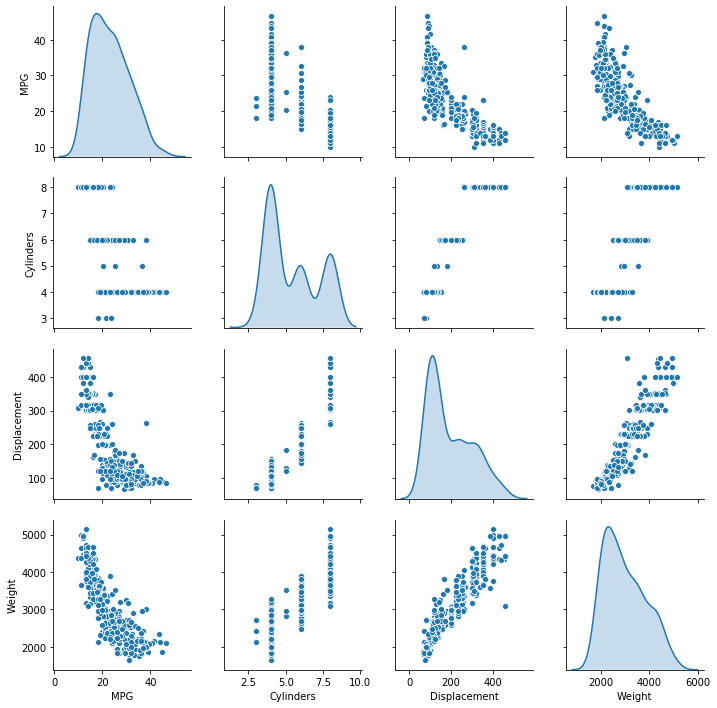

In [0]:
# Lets plot some data

sns.pairplot(train_dataset[["MPG","Cylinders","Displacement","Weight"]], diag_kind = "kde")

In [0]:
# Lets look at the overall statistics


train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

**Normalize the data**

Look again at the train_stats block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model might converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [0]:
def norm(x):
  return (x - train_stats['mean'])/ train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier. That includes the test set as well as live data when the model is used in production.

Lets now build the model

Let's build our model. Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])


  optimizer = tf.keras.optimizers.RMSprop(0.0005)

  model.compile(loss = 'mse',optimizer = optimizer, metrics = ['mae','mse'])

  return model



model = build_model()

Inspect the model

Use the .summary method to print a simple description of the model

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [0]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.20745398],
       [ 0.0278053 ],
       [ 0.25342125],
       [ 0.06138329],
       [ 0.04263674],
       [ 0.10013731],
       [ 0.10224368],
       [ 0.06577047],
       [ 0.05256831],
       [ 0.07512043]], dtype=float32)

**Train the model**

Train the model for 1000 epochs, and record the training and validation accuracy in the history object.

In [0]:
# Now it's time to train our model. But before we do that, lets do something fun. 
# While training our model, lets print some dots to display training progress. Each dot printed would represent one completed epoch

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch%100 == 0 : print('')
    print('.', end = '')


EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Visualize the model's training progress using the stats stored in the history object.

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,3.925759,1.302345,3.925759,9.338231,2.383687,9.338231,995
996,3.829223,1.275628,3.829223,9.279322,2.338511,9.279322,996
997,3.867592,1.319785,3.867591,9.252601,2.361431,9.252602,997
998,3.829615,1.282386,3.829615,9.391616,2.350502,9.391615,998
999,3.886367,1.291448,3.886367,9.420308,2.349161,9.420308,999


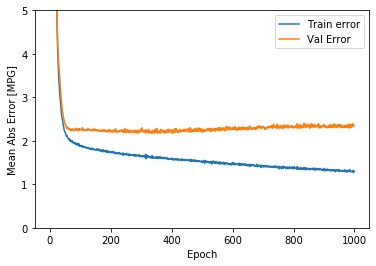

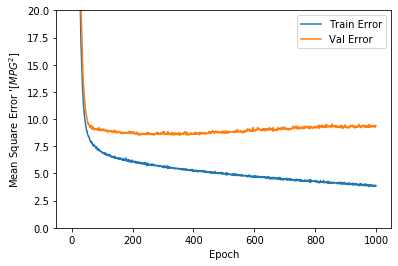

In [0]:
def plot_history(history):

  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Abs Error [MPG]")
  plt.plot(hist['epoch'],hist['mae'],label = 'Train error')

  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  
  plt.ylim([0,5])
  plt.legend()



  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Square Error '[$MPG^2$]")


  plt.plot(hist['epoch'], hist['mse'],label = "Train Error")

  plt.plot(hist['epoch'], hist['val_mse'],label = "Val Error")


  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

As we can see in the plots above, the validation error shows little improvement, or even degradation after around 100 epochs.  Let's update the model.fit call to automatically stop training when the validation score doesn't improve. We'll use an EarlyStopping callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.


....................................................................................................
............................................

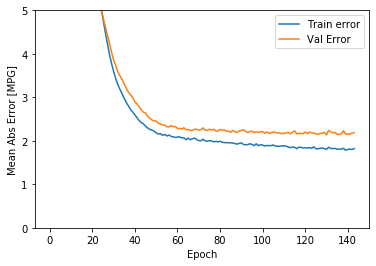

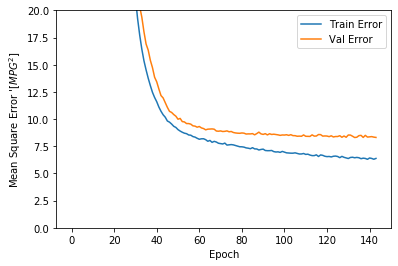

In [0]:
model = build_model()


# The patience parameter is the amount of epochs to check for improvement

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])


plot_history(history)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. 

Let's see how well the model generalizes by using the test set, which we did not use when training the model. This tells us how well we can expect the model to predict when we use it in the real world.

In [0]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.9946 - mae: 1.8436 - mse: 5.9946
Testing set Mean Abs Error:  1.84 MPG


**Make predictions**

Finally, predict MPG values using data in the testing set:

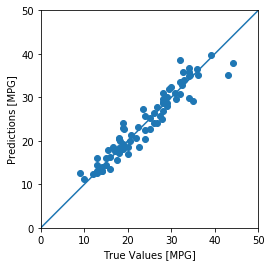

In [0]:
test_predictions = model.predict(normed_test_data).flatten()


a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)


plt.xlabel("True Values [MPG]")
plt.ylabel("Predictions [MPG]")

lim = [0,50]

plt.xlim(lim)
plt.ylim(lim)
_ = plt.plot(lim, lim)

It looks like our model predicts reasonably well. Let's take a look at the error distribution.

Text(0, 0.5, 'Count')

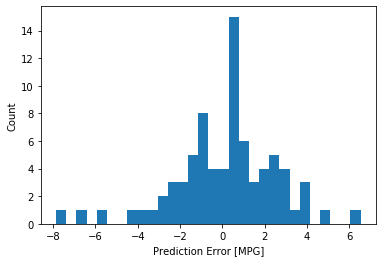

In [0]:
error = test_predictions - test_labels

plt.hist(error, bins = 30)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small.



# **Conclusion**

This notebook introduced a few techniques to handle a regression problem.

Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
Early stopping is a useful technique to prevent overfitting.